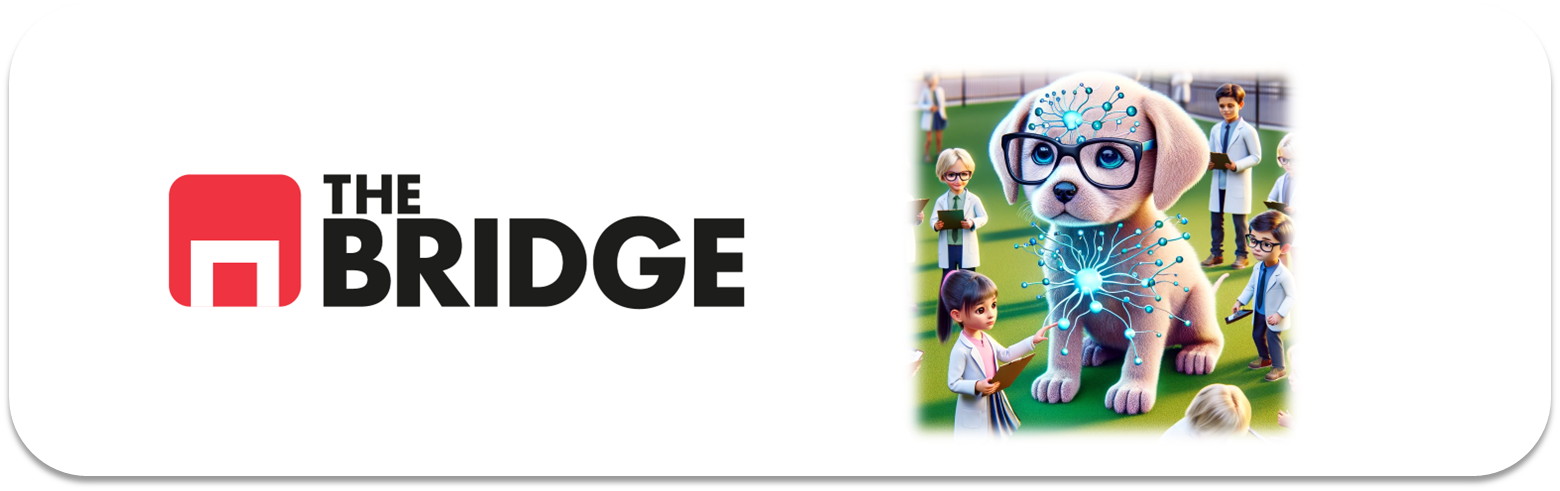

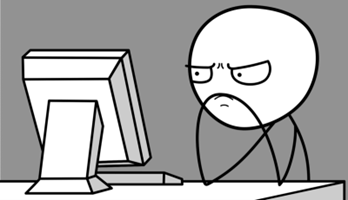

Para ejercitarte y afianzar lo aprendido sobre **Redes Recurrentes y series temporales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from pmdarima.arima import ARIMA, auto_arima
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt

### Problema a resolver

El ayuntamiento de New City está preocupado por el nivel de contaminación de aire y quiere poner en marcha un sistema de prevención del uso de determinado tipo de vehículos y maquinaria pesada en aquellos días en los que la contaminación sea muy alta, en concreto queremos anticiparnos en periodos de 6 horas. Como primer paso para la implantación de la medida, decide crear un modelo de predicción de contaminación de forma que pueda emplearlo para enviar alertas o avisos de posible de prohibición con la suficiente anticipación que permita a los ciudadanos y trabajadores organizarse mejor. 

Para ello nos ha suministrado una serie de datos de contaminación del aire en cinco años dependiente de una serie de features que son medibles día a día y nos pide crear dicho modelo. Como somos unos "pioneros" vamos a hacerlo empleando lo aprendido con redes recurrentes.

A través de los siguientes ejercicios vamos a crear un modelo de regresión que permita estimar dicha polución en los periodos estimados. Aquí tienes un breve descripción de las columnas:

- **No**: número de fila
- **year**: año de los datos en esta fila
- **month**: mes de los datos en esta fila
- **day**: día de los datos en esta fila
- **hour**: hora de los datos en esta fila
- **pm2.5**: concentración de PM2.5
- **DEWP**: Punto de rocío
- **TEMP**: Temperatura
- **PRES**: Presión
- **cbwd**: Dirección combinada del viento
- **Iws**: Velocidad acumulada del viento
- **Is**: Horas acumuladas de nieve
- **Ir**: Horas acumuladas de lluvia


### Ejercicio 1: Visión preliminar

Carga el dataset. Echa un vistazo (no pintes series todavía) y decide cuál debe ser el target.

In [2]:
df_polut=pd.read_csv("./data/air_pollution_new_city.csv",sep="|")
df_polut

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,25,2019,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,26,2019,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,27,2019,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,28,2019,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,29,2019,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,43820,2023,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,43821,2023,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,43822,2023,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,43823,2023,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [3]:
df_polut.duplicated().value_counts()

False    43800
Name: count, dtype: int64

### Ejercicio 2: Preparación del dataset

Como todo dataset con series temporales, si tenemos las fechas, es conveniente convertirla a datatime y luego hacerlo el indice de nuestro dataset. Hazlo sobre un dataframe df_indexed copia del original. Deshazte de las columnas que no sean informativas y cambia el nombre de las columnas para que sean más "expresivas".

In [4]:
df_polut.columns

Index(['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES',
       'cbwd', 'Iws', 'Is', 'Ir'],
      dtype='object')

In [5]:
df_indexed=df_polut.copy()
df_indexed["date"] = pd.to_datetime(df_indexed[['year', 'month', 'day', 'hour']])
df_indexed=df_indexed.set_index("date")
df_indexed = df_indexed.sort_index() 
df_indexed=df_indexed.drop(columns=["No",'year', 'month', 'day', 'hour'])
df_indexed.columns=['pm2.5_conc', 'pto_rocio', 'temp', 'presion', 'viento', 'veloc_viento', 'hs_nevando', 'hs_lluvia']
df_indexed=pd.get_dummies(df_indexed,columns=["viento"],dtype=int)
df_indexed

,pm2.5_conc,pto_rocio,temp,presion,veloc_viento,hs_nevando,hs_lluvia,viento_NE,viento_NW,viento_SE,viento_cv
date,,,,,,,,,,,
2019-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2019-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2019-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2019-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2019-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,8.0,-23,-2.0,1034.0,231.97,0,0,0,1,0,0
2023-12-31 20:00:00,10.0,-22,-3.0,1034.0,237.78,0,0,0,1,0,0
2023-12-31 21:00:00,10.0,-22,-3.0,1034.0,242.70,0,0,0,1,0,0


In [6]:
df_indexed.columns

Index(['pm2.5_conc', 'pto_rocio', 'temp', 'presion', 'veloc_viento',
       'hs_nevando', 'hs_lluvia', 'viento_NE', 'viento_NW', 'viento_SE',
       'viento_cv'],
      dtype='object')

### Ejercicio 3: Split y MiniEda_I

Antes de continuar es hora analizar visualmente las series, pero para hacerlo formalmente correcto, analiza sólo de 2019 a 2022 (2023 será nuestro periodo de validaciones y test). Crea una gráfica com el target para el periodo de train. Descompón la serie de forma aditiva y analiza visualmente si existe estacionalidad, tendencia y si podríamos decir si es estacionaria o no

<Axes: title={'center': 'Evolución de pm2.5_conc (2019-2022)'}, xlabel='Fecha', ylabel='Concentración de PM2.5'>

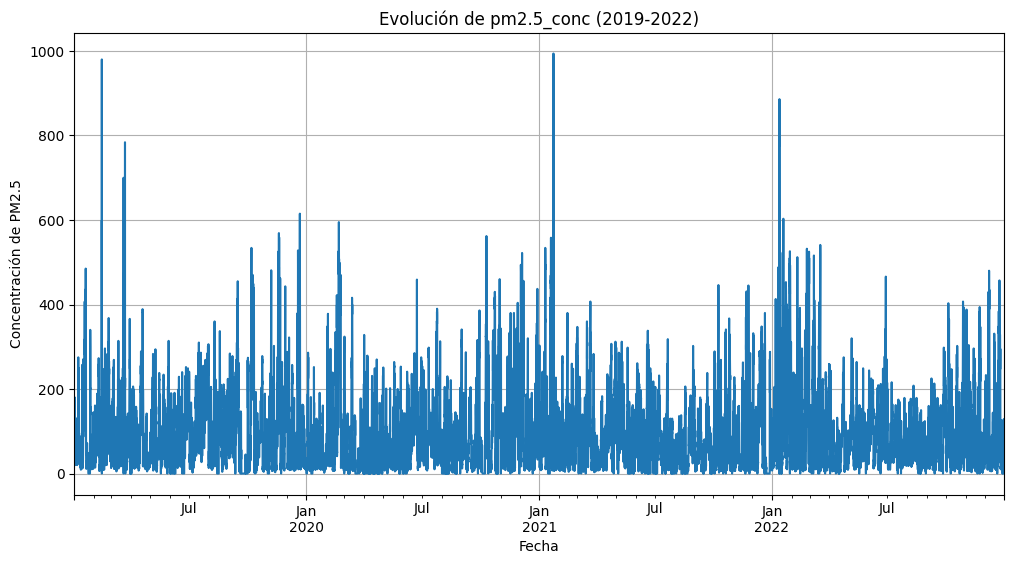

In [7]:
target='pm2.5_conc'
train_set=df_indexed["2019-01-02":"2022-12-31"]
train_set[target].plot(figsize=(12, 6), title="Evolución de pm2.5_conc (2019-2022)", ylabel="Concentración de PM2.5", xlabel="Fecha", grid=True)

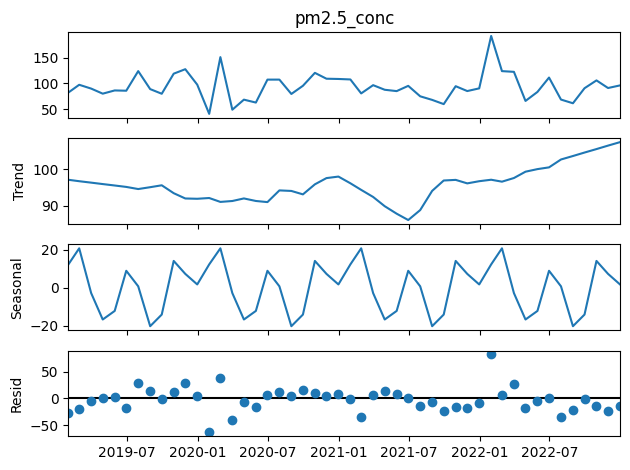

In [8]:
df_mensualizada = train_set.resample("M").mean(numeric_only= True)
result_add = seasonal_decompose(df_mensualizada[target], model = 'additive', extrapolate_trend = 'freq')
result_add.plot();

### Ejercicio 4: MiniEDA (II)

Para completar el minieda, crea una figura con tantos subplots como series temporales y en cada subplot muestra una de las series para el train. Empieza por el target y haz un pequeño análisis visual. Por supuesto, emplea sólo el train

In [9]:
def pintar_series(df):
    feats=df.columns.tolist()
    num_feat=len(feats)
    fig, axs = plt.subplots(num_feat,1, figsize=(15, num_feat*4))
    for i in range(0,num_feat):
        df[feats[i]].plot(ax=axs[i])
        axs[i].set_ylabel(feats[i])
    
    plt.xlabel("Fecha")
    plt.tight_layout()  
    plt.show()

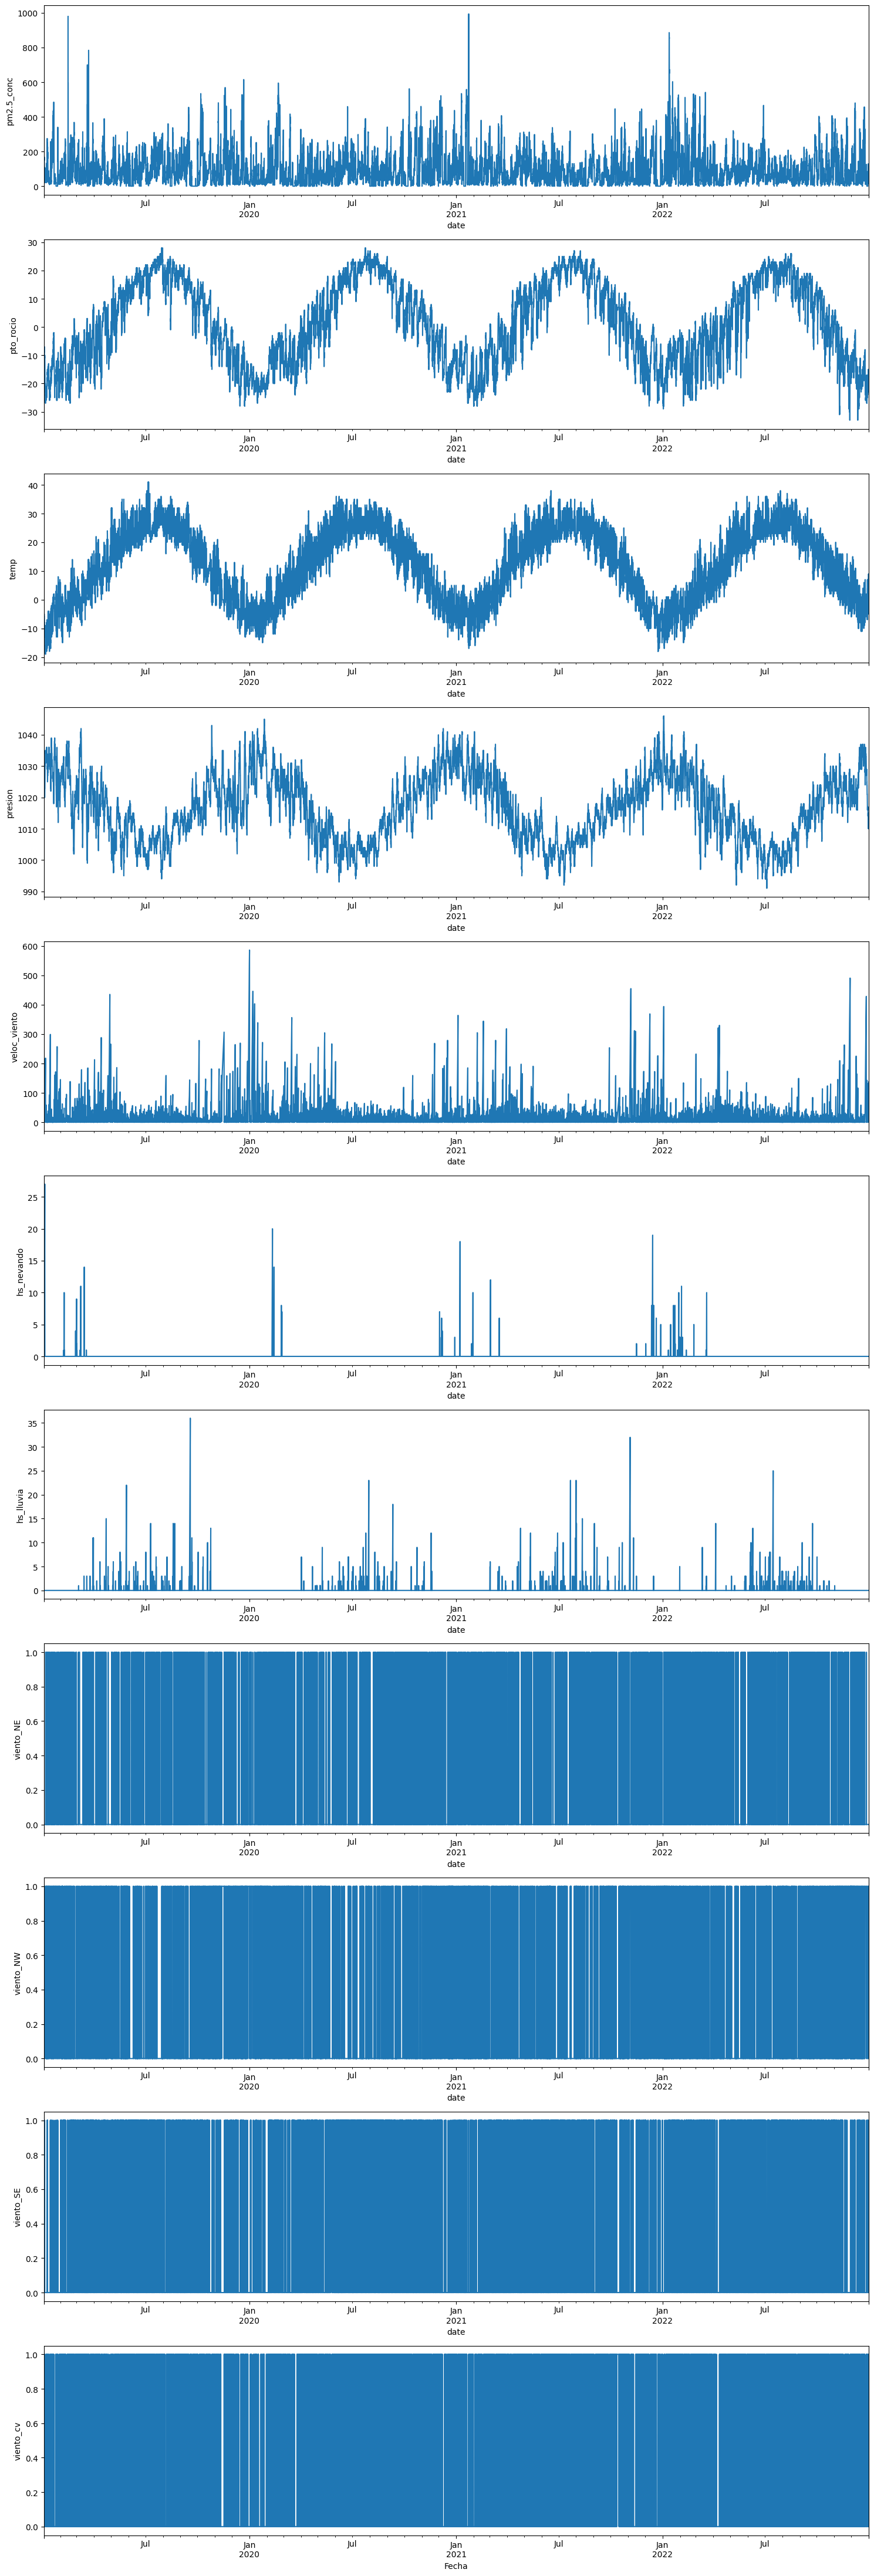

In [10]:
pintar_series(train_set)

### Ejercicio 5

Vamos a preparar el dataset. En principio vamos a predecir el valor de las siguientes 12 horas a partir de las 48 horas anteriores. Es decir hay que ajustar el dataset para que genere batches de 32 secuencias de 48 instancias y con un target que es una secuencia de los 12 periodos siguientes. Primero codifica la dirección del viento con un one-hot encoding sobre el df_indexed. Convierte todos los valores a np.float32 al final: 

In [11]:
df_indexed = df_indexed.astype(np.float32)
df_indexed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2019-01-02 00:00:00 to 2023-12-31 23:00:00
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pm2.5_conc    43800 non-null  float32
 1   pto_rocio     43800 non-null  float32
 2   temp          43800 non-null  float32
 3   presion       43800 non-null  float32
 4   veloc_viento  43800 non-null  float32
 5   hs_nevando    43800 non-null  float32
 6   hs_lluvia     43800 non-null  float32
 7   viento_NE     43800 non-null  float32
 8   viento_NW     43800 non-null  float32
 9   viento_SE     43800 non-null  float32
 10  viento_cv     43800 non-null  float32
dtypes: float32(11)
memory usage: 3.2 MB


In [12]:
# targets=df_indexed[target].to_numpy()[PAST_HOURS+FUTURE_HOURS-1:]
# ¿Por qué este índice (PAST_HOURS + FUTURE_HOURS - 1) es importante?

#PAST_HOURS=48 → Usamos 48 horas pasadas como entrada.
#FUTURE_HOURS=12 → Queremos predecir 12 horas futuras.
#Queremos que y sea el último valor de la ventana futura, que está en 48+12-1 = 59.

In [13]:
df_batch = tf.keras.utils.timeseries_dataset_from_array(
    data=df_indexed.to_numpy()[:-12],  
    targets=df_indexed[target][48+12-1:],  
    sequence_length=48,  
    batch_size=32,  
)

In [14]:
for X_batch, y_batch in df_batch.take(1):
    print(f"Forma de X_batch: {X_batch.shape}")  # (32, 48, num_features)
    print(f"Forma de y_batch: {y_batch.shape}")  # (32,)

Forma de X_batch: (32, 48, 11)
Forma de y_batch: (32,)


### Ejercicio 6

Ahora crea los datasets de train, validación y test. El primero para que tenga el periodo 2020 septiembre de 2023, el segundo para octubre de 2023 y el tercero para noviembre de 2023. Ojo ten en cuenta que vamos a necesitar tanto los valores anteriores como posteriores en los periodos (48 horas antes y 12 horas después). Escálalos (importante, escala el target por separado para poder hacer la inversión en el momento de evaluar)

In [15]:
from sklearn.preprocessing import MinMaxScaler

df_train = df_indexed.loc["2020-01-01 00:00:00":"2023-09-30 23:00:00"]
df_val = df_indexed.loc["2023-10-01 00:00:00":"2023-10-31 23:00:00"]
df_test = df_indexed.loc["2023-11-01 00:00:00":"2023-11-30 23:00:00"]

X_train, y_train = df_train.drop(columns=[target]), df_train[target]
X_val, y_val = df_val.drop(columns=[target]), df_val[target]
X_test, y_test = df_test.drop(columns=[target]), df_test[target]

In [16]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

X_train_np, y_train_np = np.array(X_train_scaled), np.array(y_train_scaled)
X_val_np, y_val_np = np.array(X_val_scaled), np.array(y_val_scaled)
X_test_np, y_test_np = np.array(X_test_scaled), np.array(y_test_scaled)

In [17]:
PAST_HOURS = 48
FUTURE_HOURS = 12
BATCH_SIZE = 32

train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=X_train_np[:-FUTURE_HOURS],  
    targets=y_train_np[PAST_HOURS+FUTURE_HOURS-1:],  
    sequence_length=PAST_HOURS,  
    batch_size=BATCH_SIZE,  
)

val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=X_val_np[:-FUTURE_HOURS],  
    targets=y_val_np[PAST_HOURS+FUTURE_HOURS-1:],  
    sequence_length=PAST_HOURS,  
    batch_size=BATCH_SIZE,  
)

test_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=X_test_np[:-FUTURE_HOURS],  
    targets=y_test_np[PAST_HOURS+FUTURE_HOURS-1:],  
    sequence_length=PAST_HOURS,  
    batch_size=BATCH_SIZE,  
)

### Ejercicio 8

Crea un modelo con una capa de celdas sencillas recurrentes con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [18]:
tf.random.set_seed(42)  
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[48, 10]),
    tf.keras.layers.Dense(1)
])
opt = tf.keras.optimizers.SGD(learning_rate=0.1)
univar_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae","mse"])
history = univar_model.fit(train_dataset, validation_data=val_dataset, epochs=50)
loss,mae,mse=univar_model.evaluate(test_dataset)

Epoch 1/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0071 - mae: 0.0866 - mse: 0.0142 - val_loss: 0.0179 - val_mae: 0.1407 - val_mse: 0.0357
Epoch 2/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0041 - mae: 0.0659 - mse: 0.0083 - val_loss: 0.0153 - val_mae: 0.1265 - val_mse: 0.0305
Epoch 3/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0038 - mae: 0.0634 - mse: 0.0076 - val_loss: 0.0140 - val_mae: 0.1195 - val_mse: 0.0279
Epoch 4/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0037 - mae: 0.0624 - mse: 0.0074 - val_loss: 0.0133 - val_mae: 0.1158 - val_mse: 0.0266
Epoch 5/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0036 - mae: 0.0619 - mse: 0.0073 - val_loss: 0.0130 - val_mae: 0.1138 - val_mse: 0.0260
Epoch 6/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0036 - mae: 0.0615 - mse: 0.0072 - val_loss: 0.0127 - val_mae: 0.1125 - val_mse: 0.0255
Epoch 7/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0035 - mae: 0.0612 - mse

In [33]:
mse_trans = scaler_y.inverse_transform([[mse]])[0, 0]
mae_trans = scaler_y.inverse_transform([[mae]])[0, 0]
print(f"MSE en unidades originales: {mse}")
print(f"MAE en unidades originales: {mae}")

MSE en unidades originales: 0.011100081726908684
MAE en unidades originales: 0.07749390602111816


### Ejercicio 9

Crea un modelo con una capa de celdas LSTM con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [36]:
tf.config.run_functions_eagerly(False)

In [37]:
tf.random.set_seed(42)  
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32,  input_shape=[48, 10]),
    tf.keras.layers.Dense(1)
])
lstm_model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), metrics=["mae","mse"])
history = lstm_model.fit(train_dataset, validation_data=val_dataset, epochs=50)
loss,mae,mse=lstm_model.evaluate(test_dataset)

Epoch 1/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0039 - mae: 0.0641 - mse: 0.0078 - val_loss: 0.0122 - val_mae: 0.1089 - val_mse: 0.0245
Epoch 2/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0035 - mae: 0.0608 - mse: 0.0071 - val_loss: 0.0116 - val_mae: 0.1053 - val_mse: 0.0231
Epoch 3/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0035 - mae: 0.0603 - mse: 0.0069 - val_loss: 0.0112 - val_mae: 0.1034 - val_mse: 0.0224
Epoch 4/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0034 - mae: 0.0600 - mse: 0.0069 - val_loss: 0.0109 - val_mae: 0.1021 - val_mse: 0.0219
Epoch 5/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0034 - mae: 0.0597 - mse: 0.0068 - val_loss: 0.0107 - val_mae: 0.1012 - val_mse: 0.0215
Epoch 6/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0034 - mae: 0.0596 - mse: 0.0068 - val_loss: 0.0106 - val_mae: 0.1005 - val_mse: 0.0212
Epoch 7/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0034 - mae

In [41]:
mse_trans = scaler_y.inverse_transform([[mse]])[0, 0]
mae_trans = scaler_y.inverse_transform([[mae]])[0, 0]
print(f"MSE en unidades originales: {mse_trans}")
print(f"MAE en unidades originales: {mae_trans}")

MSE en unidades originales: 9.38973510680953
MAE en unidades originales: 75.0562195194627


### Ejercicio 10

Crea un modelo con una capa de celdas GRU con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [39]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, input_shape=[48, 10]),
    tf.keras.layers.Dense(1)
])
lstm_model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), metrics=["mae","mse"])
history = lstm_model.fit(train_dataset, validation_data=val_dataset, epochs=50)
loss_gru,mae_gru,mse_gru=lstm_model.evaluate(test_dataset)

Epoch 1/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0032 - mae: 0.0577 - mse: 0.0064 - val_loss: 0.0090 - val_mae: 0.0929 - val_mse: 0.0180
Epoch 2/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0032 - mae: 0.0577 - mse: 0.0064 - val_loss: 0.0090 - val_mae: 0.0929 - val_mse: 0.0180
Epoch 3/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0032 - mae: 0.0577 - mse: 0.0064 - val_loss: 0.0090 - val_mae: 0.0929 - val_mse: 0.0180
Epoch 4/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0032 - mae: 0.0577 - mse: 0.0064 - val_loss: 0.0090 - val_mae: 0.0929 - val_mse: 0.0180
Epoch 5/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0032 - mae: 0.0577 - mse: 0.0064 - val_loss: 0.0090 - val_mae: 0.0929 - val_mse: 0.0180
Epoch 6/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0032 - mae: 0.0577 - mse: 0.0064 - val_loss: 0.0090 - val_mae: 0.0929 - val_mse: 0.0180
Epoch 7/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0032 - mae

In [40]:
mse_gru_trans = scaler_y.inverse_transform([[mse_gru]])[0, 0]
mae_gru_trans = scaler_y.inverse_transform([[mae_gru]])[0, 0]
print(f"MSE en unidades originales: {mse_gru_trans}")
print(f"MAE en unidades originales: {mae_gru_trans}")

MSE en unidades originales: 9.503343117191646
MAE en unidades originales: 75.03595703896822
